In [1]:
# PyTorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Scheduler - OneCycleLR, CosineAnnealingLR
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR

# PyTorch Lightning
import lightning as L

# wandb
import wandb

# Split the data into training and test sets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

In [2]:
import os
os.environ["WANDB_SILENT"] = "true"

import warnings
warnings.filterwarnings('ignore')

In [3]:
L.seed_everything(42)

Seed set to 42


42

In [4]:
df_grf = pl.read_parquet("../data/grf.parquet")
df_grf_int = pl.read_parquet("../data/grf_int.parquet")

In [5]:
n_samples = df_grf["group"].n_unique()
n_samples

10000

In [6]:
print(df_grf, df_grf_int)

shape: (10_000_000, 3)
┌───────┬──────────┬───────┐
│ x     ┆ grf      ┆ group │
│ ---   ┆ ---      ┆ ---   │
│ f64   ┆ f64      ┆ u64   │
╞═══════╪══════════╪═══════╡
│ 0.0   ┆ 0.201082 ┆ 0     │
│ 0.001 ┆ 0.201827 ┆ 0     │
│ 0.002 ┆ 0.202477 ┆ 0     │
│ 0.003 ┆ 0.203033 ┆ 0     │
│ 0.004 ┆ 0.203495 ┆ 0     │
│ …     ┆ …        ┆ …     │
│ 0.996 ┆ 0.304625 ┆ 9999  │
│ 0.997 ┆ 0.303263 ┆ 9999  │
│ 0.998 ┆ 0.301747 ┆ 9999  │
│ 0.999 ┆ 0.300075 ┆ 9999  │
│ 1.0   ┆ 0.298249 ┆ 9999  │
└───────┴──────────┴───────┘ shape: (1_000_000, 3)
┌──────┬───────────┬───────┐
│ y    ┆ grf_int   ┆ group │
│ ---  ┆ ---       ┆ ---   │
│ f64  ┆ f64       ┆ u64   │
╞══════╪═══════════╪═══════╡
│ 0.0  ┆ 0.0       ┆ 0     │
│ 0.01 ┆ 0.002035  ┆ 0     │
│ 0.02 ┆ 0.004055  ┆ 0     │
│ 0.03 ┆ 0.005968  ┆ 0     │
│ 0.04 ┆ 0.007688  ┆ 0     │
│ …    ┆ …         ┆ …     │
│ 0.96 ┆ -0.005045 ┆ 9999  │
│ 0.97 ┆ -0.00228  ┆ 9999  │
│ 0.98 ┆ 0.000709  ┆ 9999  │
│ 0.99 ┆ 0.0038    ┆ 9999  │
│ 1.0  ┆ 0.006852  ┆ 9999  

In [7]:
df_grf = df_grf.filter(pl.col("x").is_in([round(x * 0.01, 2) for x in range(101)]))
print(df_grf)

shape: (1_000_000, 3)
┌──────┬──────────┬───────┐
│ x    ┆ grf      ┆ group │
│ ---  ┆ ---      ┆ ---   │
│ f64  ┆ f64      ┆ u64   │
╞══════╪══════════╪═══════╡
│ 0.0  ┆ 0.201082 ┆ 0     │
│ 0.01 ┆ 0.204293 ┆ 0     │
│ 0.02 ┆ 0.198184 ┆ 0     │
│ 0.03 ┆ 0.183089 ┆ 0     │
│ 0.04 ┆ 0.15959  ┆ 0     │
│ …    ┆ …        ┆ …     │
│ 0.96 ┆ 0.261699 ┆ 9999  │
│ 0.97 ┆ 0.289567 ┆ 9999  │
│ 0.98 ┆ 0.306218 ┆ 9999  │
│ 0.99 ┆ 0.309601 ┆ 9999  │
│ 1.0  ┆ 0.298249 ┆ 9999  │
└──────┴──────────┴───────┘


In [8]:
x = df_grf.filter(pl.col("group") == 0)["x"].to_numpy()
y = df_grf_int.group_by("group", maintain_order=True).agg(pl.col("y"))["y"].explode().to_numpy().reshape(n_samples, -1)
grfs = df_grf.group_by("group", maintain_order=True).agg(pl.col("grf"))["grf"].explode().to_numpy().reshape(n_samples, -1)
grf_ints = df_grf_int.group_by("group", maintain_order=True).agg(pl.col("grf_int"))["grf_int"].explode().to_numpy().reshape(n_samples, -1)

y = y.astype(np.float32)
grfs = grfs.astype(np.float32)
grf_ints = grf_ints.astype(np.float32)

print(f"x: {x.shape}, y: {y.shape}")
print(f"grfs: {grfs.shape}, grf_ints: {grf_ints.shape}")

x: (100,), y: (10000, 100)
grfs: (10000, 100), grf_ints: (10000, 100)


## DeepONet from Scratch

$$
G: u \in C[\mathcal{D}] \rightarrow G(u) \in C[\mathcal{R}] \quad \text{where } \mathcal{D}, \mathcal{R} \text{ are compact}
$$
$$
u(x) \overset{G}{\longrightarrow} G(u)(y) = \int_0^y u(x) dx
$$

In [9]:
n_train = int(0.8 * n_samples)
n_val = int(0.1 * n_samples)
n_test = n_samples - n_train - n_val

grf_train = grfs[:n_train]
grf_val = grfs[n_train:n_train + n_val]
grf_test = grfs[n_train + n_val:]

y_train = y[:n_train]
y_val = y[n_train:n_train + n_val]
y_test = y[n_train + n_val:]

grf_int_train = grf_ints[:n_train]
grf_int_val = grf_ints[n_train:n_train + n_val]
grf_int_test = grf_ints[n_train + n_val:]

In [10]:
class IntegralData(Dataset):
    def __init__(self, grf, y, grf_int):
        self.grf = torch.tensor(grf)
        self.y = torch.tensor(y)
        self.grf_int = torch.tensor(grf_int)

    def __len__(self):
        return len(self.grf)

    def __getitem__(self, idx):
        return self.grf[idx], self.y[idx], self.grf_int[idx]

In [11]:
ds_train = IntegralData(grf_train, y_train, grf_int_train)
ds_val = IntegralData(grf_val, y_val, grf_int_val)
ds_test = IntegralData(grf_test, y_test, grf_int_test)

In [12]:
class DeepONetScratch(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        
        num_input = hparams["num_input"]
        num_branch = hparams["num_branch"]
        num_output = hparams["num_output"]
        dim_output = hparams["dim_output"]
        hidden_size = hparams["hidden_size"]
        hidden_depth = hparams["hidden_depth"]

        branch_net = [nn.Linear(num_input, hidden_size), nn.GELU()]
        for i in range(hidden_depth-1):
            branch_net.append(nn.Linear(hidden_size, hidden_size))
            branch_net.append(nn.GELU())
        branch_net.append(nn.Linear(hidden_size, num_branch))
        self.branch_net = nn.Sequential(*branch_net)

        trunk_net = [nn.Linear(dim_output, hidden_size), nn.GELU()]
        for _ in range(hidden_depth-1):
            trunk_net.append(nn.Linear(hidden_size, hidden_size))
            trunk_net.append(nn.GELU())
        trunk_net.append(nn.Linear(hidden_size, num_branch))
        self.trunk_net = nn.Sequential(*trunk_net)
        
        self.bias = nn.Parameter(torch.randn(num_output), requires_grad=True)

    def forward(self, u, y):
        l = y.shape[1]
        branch_out = self.branch_net(u)
        trunk_out = torch.stack([self.trunk_net(y[:, i:i+1]) for i in range(l)], dim=2)
        pred = torch.einsum("bp,bpl->bl", branch_out, trunk_out) + self.bias
        return pred

In [13]:
def train(model, optimizer, scheduler, train_loader, val_loader, epochs, device):
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for u, y, Guy in train_loader:
            u, y, Guy = u.to(device), y.to(device), Guy.to(device)
            optimizer.zero_grad()
            pred = model(u, y)
            loss = F.mse_loss(pred, Guy)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for u, y, Guy in val_loader:
                u, y, Guy = u.to(device), y.to(device), Guy.to(device)
                pred = model(u, y)
                loss = F.mse_loss(pred, Guy)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        
        scheduler.step()

        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "epoch": epoch+1})

In [14]:
def evaluate(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for u, y, Guy in test_loader:
            u, y, Guy = u.to(device), y.to(device), Guy.to(device)
            pred = model(u, y)
            loss = F.mse_loss(pred, Guy)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    return test_loss

In [15]:
dl_train = DataLoader(ds_train, batch_size=500, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=500)
dl_test = DataLoader(ds_test, batch_size=500)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


hparams = {
    "num_input": 100,
    "num_branch": 30,
    "num_output": 100,
    "dim_output": 1,
    "hidden_size": 160,
    "hidden_depth": 4,
    "learning_rate": 0.004755,
    "batch_size": 500,
    "epochs": 200
}
model = DeepONetScratch(hparams)

wandb.init(project="DeepONet", config=hparams)

optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])
scheduler = OneCycleLR(optimizer, max_lr=hparams["learning_rate"], epochs=hparams["epochs"], steps_per_epoch=len(dl_train) // hparams["batch_size"] + 1)
train(model, optimizer, scheduler, dl_train, dl_val, hparams["epochs"], device)
test_loss = evaluate(model, dl_test, device)

wandb.log({"test_loss": test_loss})
wandb.finish()

print(test_loss)

cuda
5.047853619544185e-06


In [17]:
def predict(model, u, y):
    with torch.no_grad():
        u = u.view(1, -1)
        y = y.view(1, -1)
        pred = model(u, y)
        return pred

In [18]:
(u, y, Guy) = ds_test[0]

model = model.to("cuda:0")
u = u.to("cuda:0")
y = y.to("cuda:0")
Guy_pred = predict(model, u, y).squeeze(0)

u = u.detach().cpu().numpy()
y = y.detach().cpu().numpy()
Guy = Guy.detach().cpu().numpy()
Guy_pred = Guy_pred.detach().cpu().numpy()

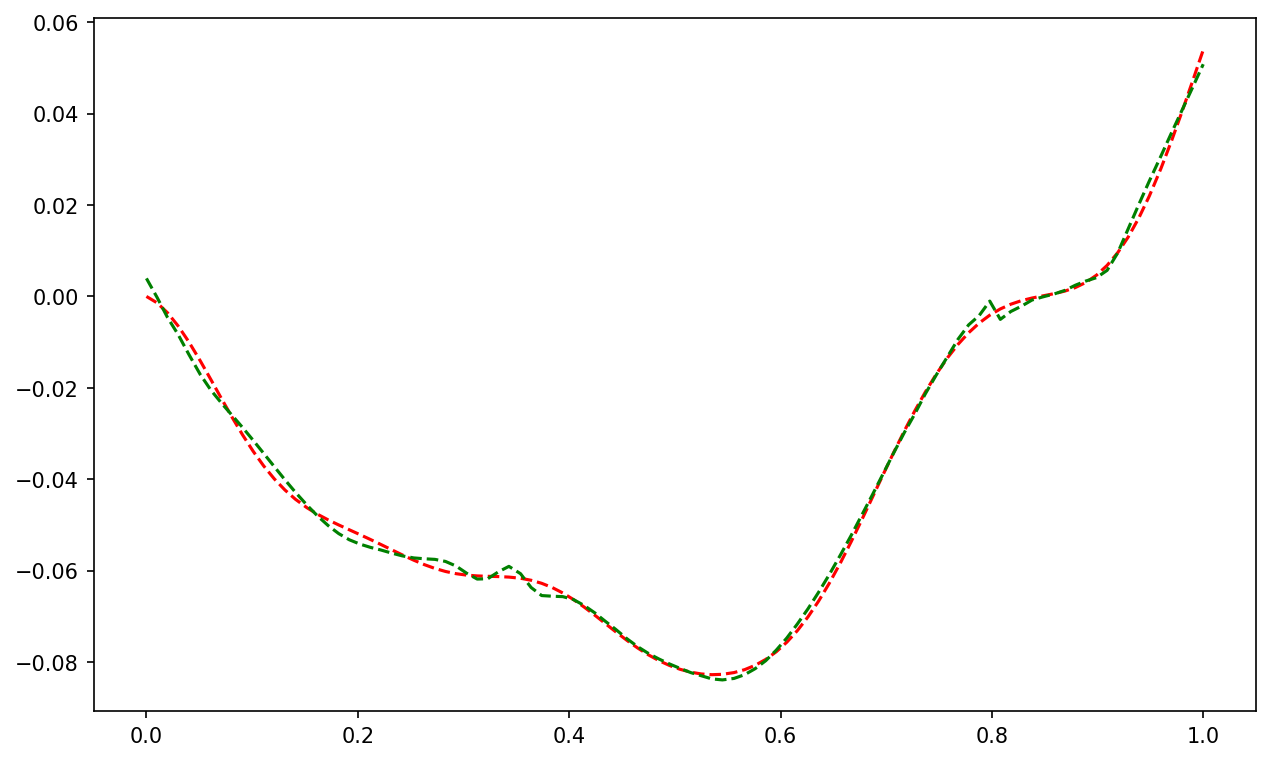

In [19]:
plt.figure(figsize=(10, 6), dpi=150)
# plt.plot(x, u, '-', color='darkblue', label="GRF")
plt.plot(y, Guy, 'r--', label="Integral")
plt.plot(y, Guy_pred, 'g--', label="Predicted Integral")
# plt.ylim(-0.5, 0.5)
plt.show()

In [20]:
x = torch.linspace(0, 1, 100).view( -1, 1).to("cuda:0")
u = (np.pi * 2 * x).cos()
y = torch.linspace(0, 1, 100).view( -1, 1).to("cuda:0")
Guy = (np.pi * 2 * y).sin() / (np.pi * 2)
Guy_pred = predict(model, u, y).squeeze(0)

u = u.detach().cpu().numpy()
y = y.detach().cpu().numpy()
Guy = Guy.detach().cpu().numpy()
Guy_pred = Guy_pred.detach().cpu().numpy()

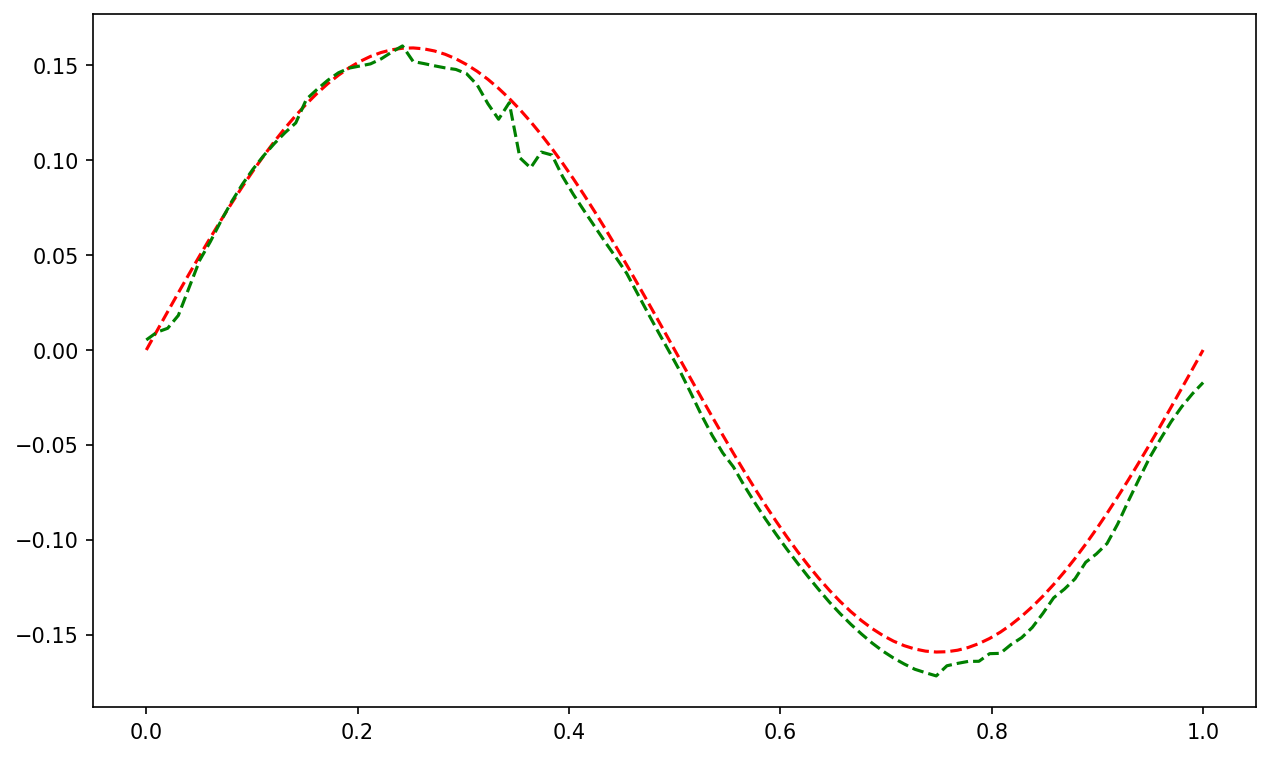

In [21]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(y, Guy, 'r--', label="Integral")
plt.plot(y, Guy_pred, 'g--', label="Predicted Integral")
plt.show()